<img src="https://github.com/djp840/MSDS_458_Public/blob/master/images/NorthwesternHeader.png?raw=1">

## MSDS422 Assignment 7
<div class="alert alert-block alert-success">
    <b>More Technical</b>: Throughout the notebook. This types of boxes provide more technical details and extra references about what you are seeing. They contain helpful tips, but you can safely skip them the first time you run through the code.
</div>

#### Microsoft Research Data License Agreement for Kaggle Cats and Dogs Dataset<br>
This Microsoft Research Data License Agreement (“Agreement”) is a legal agreement between you and Microsoft Corporation (or based on where you live, one of its affiliates). Please read them.  They apply to the Microsoft Research dataset named above, which may include any associated materials, text or speech files, associated media and “online” or electronic documentation and any updates we provide in our discretion (together, the “Dataset”). The terms also apply to any Microsoft (i) updates, (ii) supplements, (iii) internet-based services, and (iv) support services for this Dataset, unless other terms accompany those items. If so, those terms apply.
By agreeing to this Agreement and/or by using the Dataset, you accept these terms. If you do not accept them, do not use the Dataset. If you comply with these terms, you have the rights below.<br><br>
<b>SCOPE OF RIGHTS</b><br>
You may only use the Dataset:<br>
i. for non-commercial or research purposes only. Examples of non-commercial uses are teaching, academic research, public demonstrations and personal experimentation;<br>
ii. for analyzing and testing purposes; and<br>
iii. to publish (or present papers or articles) on your results from using such Dataset, provided that no material portion of the Dataset is included in any such publication or presentation.<br><br>
<b>DISCLAIMER OF WARRANTY</b><br>
The Dataset is licensed `as-is` You bear the risk of using it. Microsoft gives no express warranties, guarantees or conditions. You may have additional consumer rights or statutory guarantees under your local laws which this agreement cannot change. To the extent permitted under your local laws, Microsoft excludes the implied warranties of merchantability, fitness for a particular purpose and non-infringement.

In [1]:
# Helper libraries
import os
import zipfile
import random
import datetime
from packaging import version
import numpy as np
from IPython.display import Image, display
import matplotlib.pyplot as plt
from matplotlib import pyplot
from matplotlib.image import imread

# TensorFlow and tf.keras
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from shutil import copyfile
#from plot_keras_history import plot_history

In [2]:
%matplotlib inline
np.set_printoptions(precision=3, suppress=True)

### Verify TensorFlow Version and Keras Version

In [3]:
print("This notebook requires TensorFlow 2.0 or above")
print("TensorFlow version: ", tf.__version__)
assert version.parse(tf.__version__).release[0] >=2

This notebook requires TensorFlow 2.0 or above
TensorFlow version:  2.3.0


In [4]:
print("Keras version: ", keras.__version__)

Keras version:  2.4.0


<div class="alert alert-block alert-info">
    <b>Suppress warning messages</b></div>

In [5]:
def warn(*args, **kwargs):
    pass
import warnings
warnings.warn = warn

### Mount Google Drive to Colab Environment

In [6]:
#from google.colab import drive
#drive.mount('/content/gdrive')

<div class="alert alert-block alert-success">
    <b>If the URL doesn't work:</b><br>https://www.microsoft.com/en-us/download/confirmation.aspx?id=54765<br>
Dataset = 786.68 MiB 
</div>

### Load Cats vs Dogs Dataset

In [7]:
!wget --no-check-certificate \
    "https://download.microsoft.com/download/3/E/1/3E1C3F21-ECDB-4869-8368-6DEBA77B919F/kagglecatsanddogs_3367a.zip" \
    -O "./data/cats-and-dogs.zip"

local_zip = './data/cats-and-dogs.zip'
zip_ref   = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('./data')
zip_ref.close()

--2020-10-27 08:29:57--  https://download.microsoft.com/download/3/E/1/3E1C3F21-ECDB-4869-8368-6DEBA77B919F/kagglecatsanddogs_3367a.zip
Resolving download.microsoft.com (download.microsoft.com)... 184.84.230.134, 2600:1407:2800:3af::e59, 2600:1407:2800:38c::e59, ...
Connecting to download.microsoft.com (download.microsoft.com)|184.84.230.134|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 824894548 (787M) [application/octet-stream]
Saving to: ‘./data/cats-and-dogs.zip’

./data/cats-and-dog 100%[===================>] 786.68M  5.88MB/s    in 2m 41s  

2020-10-27 08:32:38 (4.88 MB/s) - ‘./data/cats-and-dogs.zip’ saved [824894548/824894548]



In [8]:
print(len(os.listdir('./data/PetImages/Cat/')))
print(len(os.listdir('./data/PetImages/Dog/')))

12501
12501


<div class="alert alert-block alert-warning"><b>Expected Output:</b><br>
12501 images Cat<br>
12501 images Dog</div>

In [9]:
try:
    os.mkdir('./data/cats_v_dogs')
    os.mkdir('./data/cats_v_dogs/training')
    os.mkdir('./data/cats_v_dogs/testing')
    os.mkdir('./data/cats_v_dogs/training/cats')
    os.mkdir('./data/cats_v_dogs/training/dogs')
    os.mkdir('./data/cats_v_dogs/testing/cats')
    os.mkdir('./data/cats_v_dogs/testing/dogs')
except OSError:
    pass

### Preprocessing the Examples

In [10]:
def split_data(SOURCE, TRAINING, TESTING, SPLIT_SIZE):
    files = []
    for filename in os.listdir(SOURCE):
        file = SOURCE + filename
        if os.path.getsize(file) > 0:
            files.append(filename)
        else:
            print(filename + " is zero length, so ignoring.")

    training_length = int(len(files) * SPLIT_SIZE)
    testing_length = int(len(files) - training_length)
    shuffled_set = random.sample(files, len(files))
    training_set = shuffled_set[0:training_length]
    testing_set = shuffled_set[-testing_length:]

    for filename in training_set:
        this_file = SOURCE + filename
        destination = TRAINING + filename
        copyfile(this_file, destination)

    for filename in testing_set:
        this_file = SOURCE + filename
        destination = TESTING + filename
        copyfile(this_file, destination)


CAT_SOURCE_DIR = "./data/PetImages/Cat/"
TRAINING_CATS_DIR = "./data/cats_v_dogs/training/cats/"
TESTING_CATS_DIR = "./data/cats_v_dogs/testing/cats/"
DOG_SOURCE_DIR = "./data/PetImages/Dog/"
TRAINING_DOGS_DIR = "./data/cats_v_dogs/training/dogs/"
TESTING_DOGS_DIR = "./data/cats_v_dogs/testing/dogs/"

split_size = .9
split_data(CAT_SOURCE_DIR, TRAINING_CATS_DIR, TESTING_CATS_DIR, split_size)
split_data(DOG_SOURCE_DIR, TRAINING_DOGS_DIR, TESTING_DOGS_DIR, split_size)

666.jpg is zero length, so ignoring.
11702.jpg is zero length, so ignoring.


<div class="alert alert-block alert-warning"><b>Expected Output:</b><br>
666.jpg is zero length, so ignoring<br>
11702.jpg is zero length, so ignoring<br></div>

In [11]:
print(len(os.listdir('./data/cats_v_dogs/training/cats/')))
print(len(os.listdir('./data/cats_v_dogs/training/dogs/')))
print(len(os.listdir('./data/cats_v_dogs/testing/cats/')))
print(len(os.listdir('./data/cats_v_dogs/testing/dogs/')))

11250
11250
1250
1250


<b>Expected output:</b><br>
11250 - Training Cats<br>
11250 - Training Dogs<br>
1250 - Test Cats<br>
1250 - Test Dogs<br>

## Review Images

### Cat Images

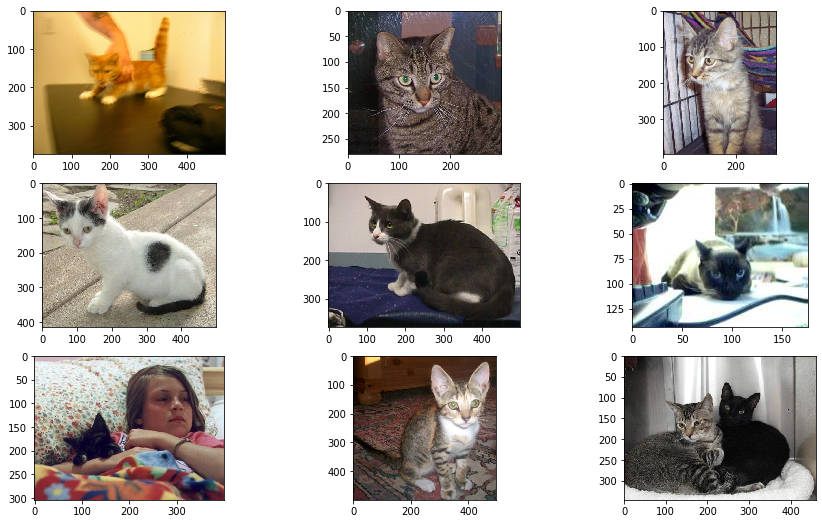

In [12]:
fig = plt.figure(figsize = (15, 9))
Catfolder = './data/PetImages/Cat/'
for i in range(9):
# define subplot
    pyplot.subplot(330 + 1 + i)
# define filename
    filename = Catfolder + str(i) + '.jpg'
# load image pixels
    image = imread(filename)
# plot raw pixel data
    pyplot.imshow(image)
# show the figure
pyplot.show()

### Dog Images

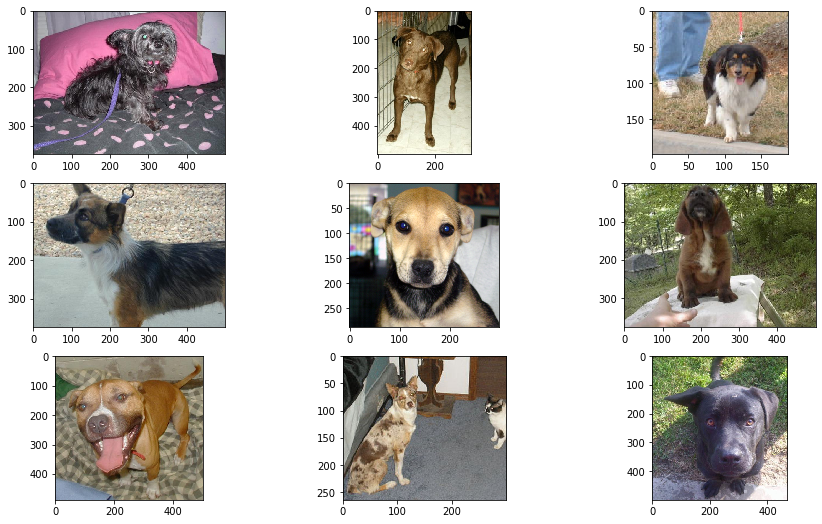

In [13]:
fig = plt.figure(figsize = (15, 9))
Dogfolder = './data/PetImages/Dog/'
for i in range(9):
# define subplot
    pyplot.subplot(330 + 1 + i)
# define filename
    filename = Dogfolder + str(i) + '.jpg'
# load image pixels
    image = imread(filename)
# plot raw pixel data
    pyplot.imshow(image)
# show the figure
pyplot.show()

### Build CNN Model

In [14]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(16, (3, 3), activation='relu', input_shape=(150, 150, 3)),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(448, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

In [15]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 148, 148, 16)      448       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 74, 74, 16)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 72, 72, 32)        4640      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 36, 36, 32)        0         
_________________________________________________________________
dropout (Dropout)            (None, 36, 36, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 34, 34, 64)        18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 17, 17, 64)        0

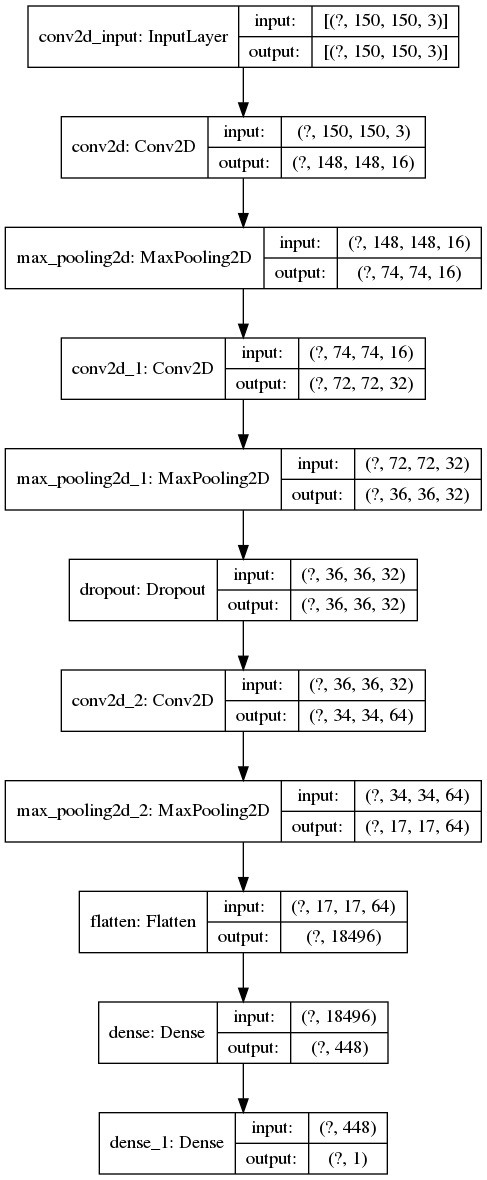

In [16]:
keras.utils.plot_model(model, "MCVD_model.png", show_shapes=True)

### Compiling the model

In addition to setting up our model architecture, we also need to define which algorithm should the model use in order to optimize the weights and biases as per the given data. We will use stochastic gradient descent.

We also need to define a loss function. Think of this function as the difference between the predicted outputs and the actual outputs given in the dataset. This loss needs to be minimised in order to have a higher model accuracy. That's what the optimization algorithm essentially does - it minimises the loss during model training. For our multi-class classification problem, categorical cross entropy is commonly used.

Finally, we will use the accuracy during training as a metric to keep track of as the model trains.

In [17]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])

### Optimizer that implements the Adam algorithm
<div class="alert alert-block alert-info">
https://www.tensorflow.org/api_docs/python/tf/keras/optimizers/Adam</div>

Adam optimization is a stochastic gradient descent method that is based on adaptive estimation of first-order and second-order moments<br>
According to Kingma et al., 2014, the method is "computationally efficient, has little memory requirement, invariant to diagonal rescaling of gradients, and is well suited for problems that are large in terms of data/parameters"

<div class="alert alert-block alert-info">
<b>tf.keras.preprocessing.image.ImageDataGenerator</b><br>
https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/image/ImageDataGenerator</div><br>
A DataFrame Iterator yielding tuples of (x, y) where x is a numpy array containing a batch of images with shape (batch_size, *target_size, channels) and y is a numpy array of corresponding labels. 

In [18]:
TRAINING_DIR = "./data/cats_v_dogs/training/"
train_datagen = ImageDataGenerator(rescale=1.0/255.)
train_generator = train_datagen.flow_from_directory(TRAINING_DIR,
                                                    batch_size=250,
                                                    class_mode='binary',
                                                    target_size=(150, 150))

VALIDATION_DIR = "./data/cats_v_dogs/testing/"
validation_datagen = ImageDataGenerator(rescale=1.0/255.)
validation_generator = validation_datagen.flow_from_directory(VALIDATION_DIR,
                                                              batch_size=250,
                                                              class_mode='binary',
                                                              target_size=(150, 150))



Found 22499 images belonging to 2 classes.
Found 2499 images belonging to 2 classes.


<div class="alert alert-block alert-warning"><b>Expected Output:</b><br>
Found 22498 images belonging to 2 classes<br>
Found 2500 images belonging to 2 classes<br></div>

### Flow From Directory 

<div class="alert alert-block alert-info">
<b>flow_from_directory - Default Parameters</b><br>
    flow_from_directory(<br>
    directory, target_size=(256, 256), color_mode='rgb', classes=None,
    class_mode='categorical', batch_size=32, shuffle=True, seed=None,
    save_to_dir=None, save_prefix='', save_format='png', follow_links=False,
    subset=None, interpolation='nearest'<br>
)<br>

Takes the path to a directory & generates batches of augmented data</div>

### Training the model

In [19]:
history = model.fit(train_generator, epochs=10
                    ,validation_data=validation_generator
                    ,validation_steps=6
                    #,callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_acc', patience=2)]
                   )

Epoch 1/10
90/90 [==============================] - 403s 4s/step - loss: 0.7290 - acc: 0.5669 - val_loss: 0.6404 - val_acc: 0.6433
Epoch 2/10
90/90 [==============================] - 405s 5s/step - loss: 0.5616 - acc: 0.7124 - val_loss: 0.5326 - val_acc: 0.7453
Epoch 3/10
90/90 [==============================] - 404s 4s/step - loss: 0.5029 - acc: 0.7512 - val_loss: 0.4841 - val_acc: 0.7713
Epoch 4/10
90/90 [==============================] - 404s 4s/step - loss: 0.4516 - acc: 0.7871 - val_loss: 0.4489 - val_acc: 0.7980
Epoch 5/10
90/90 [==============================] - 404s 4s/step - loss: 0.4236 - acc: 0.8029 - val_loss: 0.4428 - val_acc: 0.7987
Epoch 6/10
90/90 [==============================] - 405s 5s/step - loss: 0.3902 - acc: 0.8221 - val_loss: 0.4161 - val_acc: 0.8167
Epoch 7/10
90/90 [==============================] - 411s 5s/step - loss: 0.3551 - acc: 0.8427 - val_loss: 0.3889 - val_acc: 0.8227
Epoch 8/10
90/90 [==============================] - 406s 5s/step - loss: 0.3243 - a

In [20]:
# plot_history(history.history)
# plt.show()

## Plotting Performance Metrics 

We use Matplotlib to create 2 plots--displaying the training and validation loss (resp. accuracy) for each (training) epoch side by side.

In [21]:
history_dict = history.history
history_dict.keys()

dict_keys(['loss', 'acc', 'val_loss', 'val_acc'])

In [22]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

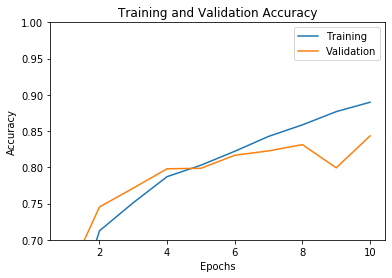

In [23]:
plt.plot(range(1, len(acc) + 1), history.history['acc'], label = 'Training')
plt.plot(range(1, len(val_acc) + 1), history.history['val_acc'], label = 'Validation')
plt.ylim([0.7, 1.0])
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

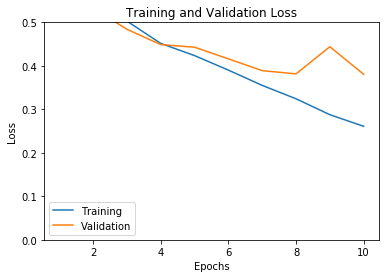

In [24]:
plt.plot(range(1, len(loss) + 1), history.history['loss'], label = 'Training')
plt.plot(range(1, len(val_loss) + 1), history.history['val_loss'], label = 'Validation')
plt.ylim([0.0, 0.5])
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [25]:
predictions = model.predict(validation_generator, validation_generator)

In [26]:
print('shape of preds: ', predictions.shape)

shape of preds:  (2499, 1)


A prediction is an array of numbers. They represent the model's "confidence" that the image corresponds to each of the 2 different classes of pets (Cats or Dogs)

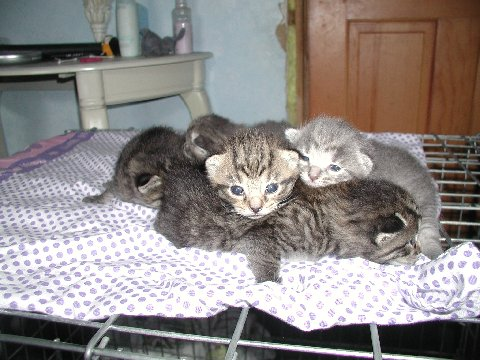

./data/PetImages/Cat/2021.jpg


In [27]:
listOfImageNames = ["./data/PetImages/Cat/2021.jpg"]
for imageName in listOfImageNames:
    display(Image(filename=imageName))
    print(imageName)

In [28]:
predictions[2021]

array([0.975], dtype=float32)

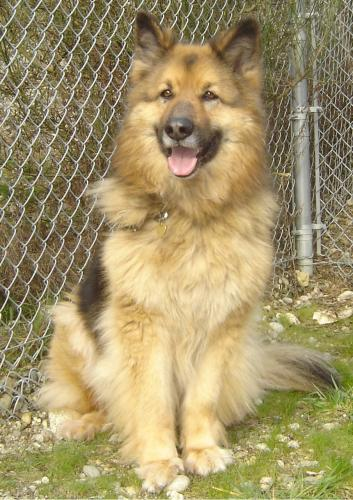

./data/PetImages/Dog/2020.jpg


In [29]:
listOfImageNames = ["./data/PetImages/Dog/2020.jpg"]
for imageName in listOfImageNames:
    display(Image(filename=imageName))
    print(imageName)

In [30]:
predictions[2020]

array([0.001], dtype=float32)